# Transfer Learning
A Convolutional Neural Network (CNN) for image classification is made up of multiple layers that extract features, such as edges, corners, etc; and then use a final fully-connected layer to classify objects based on these features. You can visualize this like this:

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*Transfer Learning* is a technique where you can take an existing trained model and re-use its feature extraction layers, replacing its final classification layer with a fully-connected layer trained on your own custom images. With this technique, your model benefits from the feature extraction training that was performed on the base model (which may have been based on a larger training dataset than you have access to) to build a classification model for your own specific set of object classes.

How does this help? Well, think of it this way. Suppose you take a professional tennis player and a complete beginner, and try to teach them both how to play raquetball. It's reasonable to assume that the professional tennis player will be easier to train, because many of the underlying skills involved in raquetball are already learned. Similarly, a pre-trained CNN model may be easier to train to classify specific set of objects because it's already learned how to identify the features of common objects, such as edges and corners.

In this notebook, we'll see how to implement transfer learning for a classification model.

> **Important**:The base model used in this exercise is large, and training is resource-intensive. Before running the code in this notebook, shut down all other notebooks in this library (In each open notebook other than this one, on the **File** menu, click **Close and Halt**). If you experience and Out-of-Memory (OOM) error when running code in this notebook, shut down this entire library, and then reopen it and open only this notebook.

## Using Transfer Learning to Train a CNN

First, we'll import the latest version of Keras and prepare to load our training data.

In [2]:

import tensorflow as tf

from tensorflow import keras

from keras import backend as K

#print('Keras version:',keras.__version__)

### Prepare the Data
Before we can train the model, we need to prepare the data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="mvNNS9teirDM8q8uuIk0")
project = rf.workspace("joseph-nelson").project("rock-paper-scissors")
version = project.version(1)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Rock-Paper-Scissors-1 in folder:: 100%|██████████| 2927/2927 [00:00<00:00, 8320.28it/s]


In [16]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras


# The images are in a folder named 'shapes/training'
training_folder_name = '/content/Rock-Paper-Scissors-1/train'

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

# Our source images are 128x128, but the base model we're going to use was trained with 224x224 images
pretrained_size = (224,224)
batch_size = 16

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


['paper', 'rock', 'scissors']
Getting Data...
Preparing training dataset...
Found 1764 images belonging to 3 classes.
Preparing validation dataset...
Found 756 images belonging to 3 classes.


### Download a trained model to use as a base
The VGG16 model is an image classifier that was trained on the ImageNet dataset - a huge dataset containing thousands of images of many kinds of object. We'll download the trained model, excluding its top layer, and set its input shape to match our image data.

*Note: The **keras.applications** namespace includes multiple base models, some which may perform better for your dataset than others. We've chosen this model because it's fairly lightweight within the limited resources of the Azure Notebooks environment.*

In [21]:
from tensorflow.keras.applications import MobileNetV2
#Load the base model, not including its final connected layer, and set the input shape to match our images
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Freeze the already trained layers and add a custom output layer for our classes
The existing feature extraction layers are already trained, so we just need to add a couple of layers so that the model output is the predictions for our classes.

In [42]:
from keras import Model
from keras.layers import Flatten, Dense
from keras import optimizers

# Freeze the already-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,446,147 (9.33 MB)

 Trainable params: 188,163 (735.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


### Train the Model
With the layers of the CNN defined, we're ready to train the top layer using our image data. This will take a considerable amount of time on a CPU due to the complexity of the base model, so we'll train the model over only one epoch.

In [43]:
# Train the model over 1 epoch using xx-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 104s 886ms/step - accuracy: 0.8629 - loss: 2.2839 - val_accuracy: 0.9774 - val_loss: 0.1005
Epoch 2/5
  1/110 ━━━━━━━━━━━━━━━━━━━━ 55s 509ms/step - accuracy: 1.0000 - loss: 2.3097e-07

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 371ms/step - accuracy: 1.0000 - loss: 2.3097e-07 - val_accuracy: 0.9787 - val_loss: 0.0843
Epoch 3/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 97s 850ms/step - accuracy: 1.0000 - loss: 1.3542e-04 - val_accuracy: 0.9801 - val_loss: 0.2117
Epoch 4/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 28s 248ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9801 - val_loss: 0.2117
Epoch 5/5
110/110 ━━━━━━━━━━━━━━━━━━━━ 113s 835ms/step - accuracy: 1.0000 - loss: 2.6935e-06 - val_accuracy: 0.9814 - val_loss: 0.2031


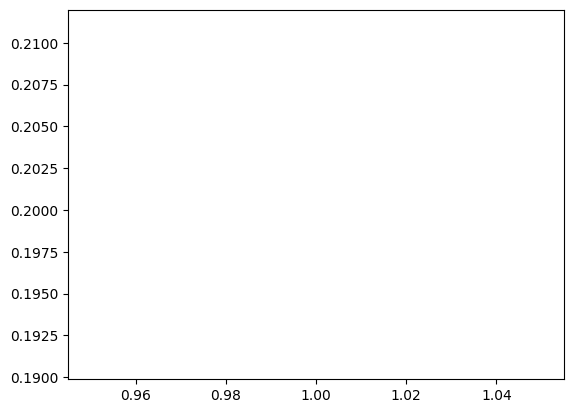

True

In [35]:
len(history.history["val_loss"])
history.history["loss"]
history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.show()
len(epoch_nums) == len(training_loss)

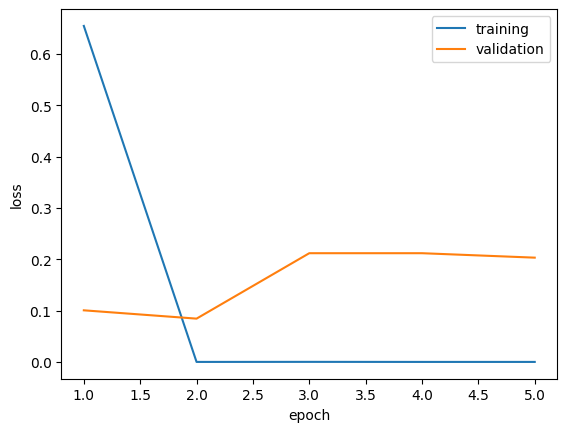

In [46]:

from matplotlib import pyplot as plt

# Get the number of validation loss values recorded during training
num_val_losses = len(history.history["val_loss"])
epoch_nums = range(1, num_val_losses + 1)

training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss[:num_val_losses]) # Plot training loss for the same number of epochs as validation loss
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### Using the Trained Model
Now that we've trained the model, we can use it to predict the class of an image.

In [47]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"):
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.LANCZOS)

    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)

    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))

    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np

    # We need to format the input to match the training data
    # The data generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    img_features = image_array.astype('float32')
    img_features /= 255

    # These are the classes our model can predict
    classnames = ['paper', 'rock', 'scissors']

    # Predict the class of each input image
    predictions = classifier.predict(img_features)

    predicted_classes = []
    for prediction in predictions:
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(class_idx)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


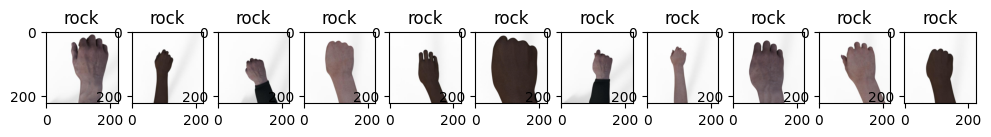

In [49]:
import os
from random import randint
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

#get the list of test image files
test_folder = '/content/Rock-Paper-Scissors-1/test/rock'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (224,224)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))

    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))

    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


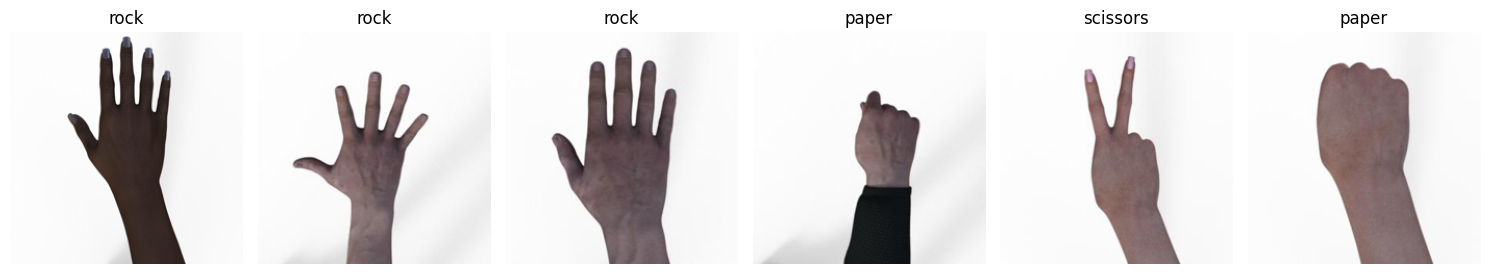

In [54]:
import os
import random
import numpy as np
from PIL import Image
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

# Your model must be loaded before predictions
# model = load_model('your_model.h5')

# Helper: Resize image function
def resize_image(img, size=(224, 224), background_color="white"):
    # Resize and convert to RGB with background if needed
    img = img.convert("RGBA")
    background = Image.new("RGBA", img.size, background_color)
    img = Image.alpha_composite(background, img).convert("RGB")
    return img.resize(size)

# Helper: Dummy prediction function (replace with your model prediction logic)
def predict_image(model, image_array):
    # Example: model.predict returns probabilities; get class index and label
    class_names = ['rock', 'paper', 'scissors']
    preds = model.predict(image_array)
    return [class_names[np.argmax(p)] for p in preds]

# Define folder paths
base_test_folder = '/content/Rock-Paper-Scissors-1/test'
class_folders = ['rock', 'paper', 'scissors']

# Collect image paths from all subfolders
all_image_paths = []
for class_folder in class_folders:
    folder_path = os.path.join(base_test_folder, class_folder)
    files = os.listdir(folder_path)
    for f in files:
        full_path = os.path.join(folder_path, f)
        all_image_paths.append(full_path)

# Shuffle and select N random images
random.shuffle(all_image_paths)
selected_image_paths = all_image_paths[:6]  # Show 6 images

# Load and preprocess images
image_arrays = []
for path in selected_image_paths:
    img = Image.open(path)
    resized_img = np.array(resize_image(img))
    image_arrays.append(resized_img)

# Convert to numpy array and predict
input_array = np.array(image_arrays)
predictions = predict_image(model, input_array)

# Plot results
fig = plt.figure(figsize=(15, 5))
for idx, (img, pred) in enumerate(zip(image_arrays, predictions)):
    ax = fig.add_subplot(1, len(predictions), idx + 1)
    ax.imshow(img)
    ax.set_title(pred)
    ax.axis('off')
plt.tight_layout()
plt.show()
